In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1. Grid setup
# ----------------------------
nx, ny, nz = 64, 64, 64           # number of cells
dx, dy, dz = 100.0, 100.0, 100.0  # grid spacing in meters
Lx, Ly, Lz = nx * dx, ny * dy, nz * dz

x = np.linspace(0, Lx, nx, endpoint=False)
y = np.linspace(0, Ly, ny, endpoint=False)
z = np.linspace(0, Lz, nz, endpoint=False)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# ----------------------------
# 2. Physical constants
# ----------------------------
g   = 9.81           # gravity (m/s^2)
cp  = 1004.0         # specific heat of air (J/kg/K)
Lv  = 2.5e6          # latent heat of vaporization (J/kg)
theta0_surf = 300.0  # surface potential temperature (K)
Gamma = 3.0 / 1000.0 # background gradient (K/m)
qv0_surf = 0.012     # surface water vapor mixing ratio (kg/kg)
rho0 = 1.0           # reference density (Boussinesq constant)
nu = 10.0            # kinematic viscosity (m^2/s)
kappa = 10.0         # thermal diffusivity (m^2/s)
Dq = 10.0            # moisture diffusivity (m^2/s)

# ----------------------------
# 3. Time setup
# ----------------------------
dt = 0.5    # seconds
t = 0.0
t_end = 600.0  # total time in seconds (10 minutes)

# ----------------------------
# 4. Background profiles
# ----------------------------
theta_bg = theta0_surf + Gamma * Z
qv_bg = qv0_surf * np.exp(-Z / 2000.0)  # exponential decay with height

# ----------------------------
# 5. State variables
# ----------------------------
u = np.zeros((nx, ny, nz))
v = np.zeros((nx, ny, nz))
w = np.zeros((nx, ny, nz))

theta_prime = np.zeros((nx, ny, nz))  # perturbation potential temperature
qv = qv_bg.copy()                     # water vapor
qc = np.zeros((nx, ny, nz))           # cloud water
pi_prime = np.zeros((nx, ny, nz))     # pressure perturbation

# ----------------------------
# 6. Initial thermal bubble
# ----------------------------
bubble_center = (Lx/2, Ly/2, 300.0)
bubble_radius = 500.0
dtheta = 1.5  # K
dqv = 0.0015  # kg/kg

r2 = (X - bubble_center[0])**2 + (Y - bubble_center[1])**2 + (Z - bubble_center[2])**2
mask = r2 < bubble_radius**2
theta_prime[mask] += dtheta * np.exp(-r2[mask] / bubble_radius**2)
qv[mask] += dqv * np.exp(-r2[mask] / bubble_radius**2)

print("Initialized 3D moist Boussinesq domain.")
print(f"Domain: {Lx/1000:.1f} x {Ly/1000:.1f} x {Lz/1000:.1f} km")
print(f"Grid: {nx} x {ny} x {nz}, Δ = {dx:.0f} m")


Initialized 3D moist Boussinesq domain.
Domain: 6.4 x 6.4 x 6.4 km
Grid: 64 x 64 x 64, Δ = 100 m


In [80]:
def _zeros_like_state(state):
    return {
        'u':       np.zeros_like(state['u']),
        'v':       np.zeros_like(state['v']),
        'w':       np.zeros_like(state['w']),
        'theta_l': np.zeros_like(state['theta_l']),
        'qt':      np.zeros_like(state['qt']),
        'qc':      np.zeros_like(state['qc']),
        # diagnostics not strictly needed in RHS, but keep for completeness
        'theta_p': np.zeros_like(state['theta_l']),
        'qv':      np.zeros_like(state['qt']),
    }

def _copy_state(state):
    return {
        'u':       state['u'].copy(),
        'v':       state['v'].copy(),
        'w':       state['w'].copy(),
        'theta_l': state['theta_l'].copy(),
        'qt':      state['qt'].copy(),
        'qc':      state['qc'].copy(),
        'theta_p': state.get('theta_p', np.zeros_like(state['theta_l'])).copy(),
        'qv':      state.get('qv',      np.zeros_like(state['qt'])).copy(),
        'pi':      state.get('pi',      np.zeros_like(state['u'])).copy(),
    }


In [4]:
# 2nd-order upwind advection for scalars and velocity + wiring into compute_rhs + tests.
# Periodic boundaries in all directions. Returns RHS tendencies (no time integration inside).
#
# What this does:
#   Advection computes the conservative form:  ∂φ/∂t = -∇·(φ U)
#   We build face fluxes Fx,Fy,Fz using a 2nd-order upwind interpolation of φ to faces,
#   with face velocities from centered averages. Then take the flux divergence.
#
# Note:
#   - This is a pure RHS operator. You still use RK2 (or any scheme) outside to advance in time.
#   - Periodic in x,y,z via np.roll.
#
import numpy as np

def _face_average(a, axis):
    """Centered average to faces along 'axis' with periodic wrap: a_{i+1/2} = 0.5*(a_i + a_{i+1})."""
    return 0.5 * (a + np.roll(a, -1, axis=axis))

def _upwind2_to_faces(phi, vel_faces, axis):
    """
    2nd-order upwind interpolation of phi to faces along 'axis', using periodic BCs.
    For each face, choose the upwind-biased stencil based on sign of face velocity.
      If u_face > 0:  phi_{i+1/2} ≈ (3/2) phi_i   - (1/2) phi_{i-1}
      If u_face < 0:  phi_{i+1/2} ≈ (3/2) phi_{i+1} - (1/2) phi_{i+2}
    """
    phi_i   = phi
    phi_im1 = np.roll(phi,  1, axis=axis)
    phi_ip1 = np.roll(phi, -1, axis=axis)
    phi_ip2 = np.roll(phi, -2, axis=axis)

    # candidate reconstructions
    phi_face_pos = 1.5*phi_i   - 0.5*phi_im1
    phi_face_neg = 1.5*phi_ip1 - 0.5*phi_ip2

    # select by velocity sign
    return np.where(vel_faces > 0.0, phi_face_pos, phi_face_neg)

def advect_scalar(phi, u, v, w, dx, dy, dz):
    """
    2nd-order upwind scalar advection RHS: dphi/dt = -∇·(phi U).
    Inputs:
      phi: scalar field (nx,ny,nz)
      u,v,w: velocity components at cell centers (nx,ny,nz)
      dx,dy,dz: grid spacings
    Output:
      rhs (same shape): advection tendency
    """
    # Face velocities (centered average to faces)
    ux = _face_average(u, axis=0)  # shape (nx,ny,nz), interpreted at i+1/2 faces
    vy = _face_average(v, axis=1)  # j+1/2
    wz = _face_average(w, axis=2)  # k+1/2

    # Upwind 2nd-order scalar to faces
    phi_xf = _upwind2_to_faces(phi, ux, axis=0)
    phi_yf = _upwind2_to_faces(phi, vy, axis=1)
    phi_zf = _upwind2_to_faces(phi, wz, axis=2)

    # Fluxes at faces
    Fx = ux * phi_xf
    Fy = vy * phi_yf
    Fz = wz * phi_zf

    # Divergence of flux (periodic): (F_{i+1/2}-F_{i-1/2})/dx, etc.
    dFx = (np.roll(Fx, -1, axis=0) - Fx) / dx
    dFy = (np.roll(Fy, -1, axis=1) - Fy) / dy
    dFz = (np.roll(Fz, -1, axis=2) - Fz) / dz

    rhs = -(dFx + dFy + dFz)
    return rhs

def advect_velocity(u, v, w, dx, dy, dz):
    """
    2nd-order upwind advection for velocity components (component-wise passive advection):
      du/dt = -∇·(u U),  dv/dt = -∇·(v U),  dw/dt = -∇·(w U),
    where U=(u,v,w) is the advecting velocity field.
    Returns three RHS arrays.
    """
    rhs_u = advect_scalar(u, u, v, w, dx, dy, dz)
    rhs_v = advect_scalar(v, u, v, w, dx, dy, dz)
    rhs_w = advect_scalar(w, u, v, w, dx, dy, dz)
    return rhs_u, rhs_v, rhs_w

In [5]:
# -----------------
# Laplacian (periodic) and diffusion operators
# -----------------
def laplacian_periodic(phi, dx, dy, dz):
    """
    3D Laplacian with periodic boundaries in all directions.
    Centered 2nd-order finite differences.
    """
    # roll implements periodic neighbors
    d2x = (np.roll(phi, -1, axis=0) - 2.0*phi + np.roll(phi,  1, axis=0)) / (dx*dx)
    d2y = (np.roll(phi, -1, axis=1) - 2.0*phi + np.roll(phi,  1, axis=1)) / (dy*dy)
    d2z = (np.roll(phi, -1, axis=2) - 2.0*phi + np.roll(phi,  1, axis=2)) / (dz*dz)
    return d2x + d2y + d2z

def diffuse_scalar(phi, kappa, dx, dy, dz):
    """
    Return diffusion tendency for a scalar field: dphi/dt = kappa * Laplacian(phi).
    """
    if kappa == 0.0:
        return np.zeros_like(phi)
    return kappa * laplacian_periodic(phi, dx, dy, dz)

def diffuse_velocity(u, v, w, nu, dx, dy, dz):
    """
    Return diffusion tendencies for velocity components: du/dt = nu * Laplacian(u), etc.
    """
    if nu == 0.0:
        z = np.zeros_like(u)
        return z, z.copy(), z.copy()
    Lu = laplacian_periodic(u, dx, dy, dz)
    Lv = laplacian_periodic(v, dx, dy, dz)
    Lw = laplacian_periodic(w, dx, dy, dz)
    return nu * Lu, nu * Lv, nu * Lw

In [75]:
def compute_buoyancy(theta_p, qv, qc, theta0, g=9.81):
    """
    Buoyancy for moist Boussinesq:
      b = g * ( theta'/theta0 + 0.61*qv - qc )
    Inputs:
      theta_p: potential temperature perturbation θ' (K)
      qv: water vapor mixing ratio (kg/kg)
      qc: cloud liquid water mixing ratio (kg/kg)
      theta0: background potential temperature θ0(z) or 3D broadcast (K)
      g: gravity (m/s^2)
    Output:
      b: buoyancy (m/s^2), same shape
    """
    return g * ( (theta_p / theta0) + 0.61*qv - qc )
    # return g * (theta_p / theta0)

def theta_rhs_extra(w, dtheta0_dz):
    """
    Background cooling/heating due to motion through stratification:
      ∂θ'/∂t |_bg = - w * dθ0/dz
    Inputs:
      w: vertical velocity (m/s)
      dtheta0_dz: vertical gradient of background θ0 (K/m)
    Output:
      rhs_theta_extra: same shape

      how temperature change is handled relative to altitude/vertical velocity. as you rise it gets cooler, this is what handles this
    """
    return - w * dtheta0_dz

# ---- Wiring helper: how to add into compute_rhs ----
def add_buoyancy_and_theta_to_rhs(state, params, rhs):
    """
    Mutates rhs in-place to include:
      - w-tendency from buoyancy (+b)
      - theta' tendency from background cooling (-w dθ0/dz)
    Expects in params:
      theta0 : 3D array (or broadcastable) of θ0
      dtheta0_dz : 3D array (or broadcastable) of dθ0/dz
      g : gravity (optional)
    """
    g = params.get('g', 9.81)
    theta0 = params['theta0']
    dthdz  = params['dtheta0_dz']

    b = compute_buoyancy(state['theta_p'], state['qv'], state['qc'], theta0, g=g)
    rhs['w']       += b
    rhs['theta_p'] += theta_rhs_extra(state['w'], dthdz)

In [7]:
# --- Thermo helpers ---
def exner(p, p_ref=1.0e5, R=287.0, cp=1004.0):
    """Exner function Π = (p/p_ref)^(R/cp)."""
    return (p / p_ref) ** (R / cp)

def saturation_vapor_pressure_water(T):
    """
    Saturation vapor pressure over liquid water (Pa).
    Using Bolton (1980)-style Magnus formula:
      es(hPa) = 6.112 * exp(17.67*(T-273.15)/(T-29.65))
    Convert to Pa by *100.
    """
    Tc = T - 273.15
    es_hPa = 6.112 * np.exp(17.67 * Tc / (Tc + 243.5))  # using 243.5 vs 29.65 in denominator (common variant)
    return es_hPa * 100.0

def saturation_mixing_ratio(T, p, epsilon=0.622):
    """
    Saturation mixing ratio q_s(T,p) = epsilon * es / (p - es), kg/kg.
    T in K, p in Pa.
    """
    es = saturation_vapor_pressure_water(T)
    es = np.minimum(es, 0.99 * p)  # safety clamp to avoid division blow-up
    return epsilon * es / (p - es)

# --- Microphysics: saturation adjustment
def microphysics_saturation_adjust(theta_p, qv, qc, theta0, p0,
                                   Lv=2.5e6, cp=1004.0, R=287.0, p_ref=1.0e5,
                                   eps=0.622, tol=1e-12):
    """
    In-place saturation adjustment at each cell:
      If qv > qs: condense Δ=qv-qs -> qv-=Δ, qc+=Δ, theta_p += (Lv/(cp*Pi))*Δ
      If qv < qs and qc>0: evaporate Δ=min(qs-qv, qc) -> qv+=Δ, qc-=Δ, theta_p -= (Lv/(cp*Pi))*Δ
    Inputs may be scalars or numpy arrays (broadcastable to a common shape).
    All arrays are modified in place.
    """
    # Compute Exner and T from (theta0 + theta_p)
    Pi = exner(p0, p_ref=p_ref, R=R, cp=cp)
    theta = theta0 + theta_p
    T = theta * Pi

    qs = saturation_mixing_ratio(T, p0, epsilon=eps)

    # Supersaturation mask -> condensation
    d_cond = np.where(qv > qs + tol, qv - qs, 0.0)
    qv = np.subtract(qv, d_cond)
    qc = np.add(qc, d_cond)
    theta_p = np.add(theta_p, (Lv / (cp * Pi)) * d_cond)

    # Sub-saturation + available cloud water -> evaporation
    # Recompute T and qs after possible condensation? For instant adjustment we can reuse qs;
    # the latent update slightly changes T, but to keep it simple & consistent with "single step",
    # we can allow one pass. A second pass would refine toward exact saturation.
    need = np.maximum(qs - qv - tol, 0.0)            # how much vapor is needed to reach qs
    d_evap = np.minimum(need, qc)                    # can only evaporate what exists
    qv = np.add(qv, d_evap)
    qc = np.subtract(qc, d_evap)
    theta_p = np.subtract(theta_p, (Lv / (cp * Pi)) * d_evap)

    # clip tiny negatives
    qv = np.maximum(qv, 0.0)
    qc = np.maximum(qc, 0.0)

    return theta_p, qv, qc

In [8]:
def _wavenumbers(n, d):
    """
    Angular wavenumbers for periodic FFT derivatives.
    k = 2π * fftfreq(n, d)
    """
    return 2.0 * np.pi * np.fft.fftfreq(n, d=d)

def project_velocity(u, v, w, dx, dy, dz):
    """
    Periodic FFT-based projection.
    Inputs:
      u,v,w : 3D arrays of provisional velocity (cell-centered)
      dx,dy,dz : grid spacings
    Returns:
      u_corr, v_corr, w_corr, psi  (all real-valued 3D arrays)
    """
    # FFTs of components
    U = np.fft.fftn(u)
    V = np.fft.fftn(v)
    W = np.fft.fftn(w)

    nx, ny, nz = u.shape
    kx = _wavenumbers(nx, dx)[:, None, None]
    ky = _wavenumbers(ny, dy)[None, :, None]
    kz = _wavenumbers(nz, dz)[None, None, :]

    # Divergence in spectral space: div_k = i(kx U + ky V + kz W)
    i = 1j
    div_k = i*(kx*U + ky*V + kz*W)

    # Solve Laplace: ∇²ψ = div  =>  -k^2 ψ_k = div_k  => ψ_k = -div_k / k^2
    k2 = kx**2 + ky**2 + kz**2
    psi_k = np.zeros_like(U, dtype=complex)
    mask = k2 != 0.0
    psi_k[mask] = -div_k[mask] / k2[mask]
    psi_k[~mask] = 0.0  # zero-mean gauge

    # Gradient of psi in spectral space
    Gx_k = i * kx * psi_k
    Gy_k = i * ky * psi_k
    Gz_k = i * kz * psi_k

    # Corrected velocities
    Uc = U - Gx_k
    Vc = V - Gy_k
    Wc = W - Gz_k

    u_corr = np.fft.ifftn(Uc).real
    v_corr = np.fft.ifftn(Vc).real
    w_corr = np.fft.ifftn(Wc).real
    psi    = np.fft.ifftn(psi_k).real

    return u_corr, v_corr, w_corr, psi

In [92]:
def diagnose_thermo(state, params):
    """
    Given prognostic (theta_l, qt, qc), compute diagnostic:
      theta, theta_p, qv.
    """
    theta0 = params['theta0']
    Lv = params['Lv']; cp = params['cp']
    p0 = params['p0']; p_ref = params.get('p_ref', 1.0e5)
    R = params['R']

    Pi = exner(p0, p_ref=p_ref, R=R, cp=cp)
    if np.ndim(Pi) == 0:
        Pi = np.full_like(theta0, Pi)
    else:
        Pi = np.array(Pi, dtype=float)

    theta_l = state['theta_l']
    qt      = state['qt']
    qc      = state['qc']

    qc = np.maximum(qc, 0.0)
    qv = np.maximum(qt - qc, 0.0)

    theta = theta_l + (Lv / (cp * Pi)) * qc
    theta_p = theta - theta0

    return theta, theta_p, qv


In [139]:
# Minimal RK2 scaffold for your first step.
# - compute_rhs: returns zero tendencies (stub)
# - project_velocity: identity (no-op)
# - step_rk2: orchestrates RK2 calls following the choreography
#
# Includes a tiny smoke test to confirm that with zero RHS and identity projection,
# the state remains unchanged after one step.

def microphysics_saturation_adjust_state(state, params,
                                         tol=1e-10, iters=4):
    """
    Reversible saturation adjust:
      - Conserves theta_l and qt.
      - Updates qc, and diagnostic qv, theta_p.
    """
    theta0 = params['theta0']
    Lv = params['Lv']; cp = params['cp']
    p0 = params['p0']; p_ref = params.get('p_ref', 1.0e5)
    R = params['R']; eps = params['eps']

    Pi = exner(p0, p_ref=p_ref, R=R, cp=cp)
    if np.ndim(Pi) == 0:
        Pi = np.full_like(theta0, Pi)
    else:
        Pi = np.array(Pi, dtype=float)

    theta_l = state['theta_l']
    qt      = state['qt']
    qc      = np.maximum(state['qc'], 0.0)

    # allocate
    qc_new = qc.copy()

    # helper: saturation mixing ratio
    def qs_fun(T, p):
        es = saturation_vapor_pressure_water(T)
        es = np.minimum(es, 0.99*p)
        return eps * es / (p - es)

    # try unsaturated assumption: all liquid evaporated
    T_all_v = theta_l * Pi
    qs_all_v = qs_fun(T_all_v, p0)
    unsat = (qt <= qs_all_v + tol)

    # set unsat cells
    qv_unsat = qt[unsat]
    qc_new[unsat] = 0.0

    # saturated cells: need qc > 0 such that qv = qt - qc = qs(T(qc))
    sat = ~unsat
    if np.any(sat):
        theta_l_s = theta_l[sat]
        qt_s      = qt[sat]
        Pi_s      = Pi[sat]
        p_s       = p0 if np.ndim(p0)==0 else p0[sat]

        # initial guess (condense just enough):
        qc_guess = np.clip(qt_s - qs_all_v[sat], 0.0, qt_s)

        for _ in range(iters):
            theta_guess = theta_l_s + (Lv / (cp * Pi_s)) * qc_guess
            T_guess = theta_guess * Pi_s
            qs_guess = qs_fun(T_guess, p_s)

            f = qt_s - qc_guess - qs_guess  # want f=0

            dT = 0.1
            qs_Tplus = qs_fun(T_guess + dT, p_s)
            dqs_dT = (qs_Tplus - qs_guess) / dT
            dqs_dqc = dqs_dT * (Lv / cp)

            denom = -1.0 - dqs_dqc
            denom = np.where(np.abs(denom) < 1e-6, -1.0, denom)
            qc_guess = qc_guess - f / denom
            qc_guess = np.clip(qc_guess, 0.0, qt_s)

        qc_new[sat] = qc_guess

    # finalize
    qc_new = np.maximum(qc_new, 0.0)
    qv_new = np.maximum(qt - qc_new, 0.0)

    # update diagnostics: theta, theta_p
    theta = theta_l + (Lv / (cp * Pi)) * qc_new
    theta_p = theta - theta0

    state['qc']      = qc_new
    state['qv']      = qv_new
    state['theta_p'] = theta_p


def advect_scalar(phi, u, v, w, dx, dy, dz):
    """
    First-order upwind scalar advection:
      dphi/dt = -∇·(phi U)
    Periodic in all directions. Monotone and robust for debugging.
    """
    # x-direction faces
    ux = 0.5 * (u + np.roll(u, -1, axis=0))
    phi_L = phi
    phi_R = np.roll(phi, -1, axis=0)
    phi_xf = np.where(ux > 0.0, phi_L, phi_R)
    Fx = ux * phi_xf

    # y-direction faces
    vy = 0.5 * (v + np.roll(v, -1, axis=1))
    phi_L = phi
    phi_R = np.roll(phi, -1, axis=1)
    phi_yf = np.where(vy > 0.0, phi_L, phi_R)
    Fy = vy * phi_yf

    # z-direction faces
    wz = 0.5 * (w + np.roll(w, -1, axis=2))
    phi_L = phi
    phi_R = np.roll(phi, -1, axis=2)
    phi_zf = np.where(wz > 0.0, phi_L, phi_R)
    Fz = wz * phi_zf

    dFx = (np.roll(Fx, -1, axis=0) - Fx) / dx
    dFy = (np.roll(Fy, -1, axis=1) - Fy) / dy
    dFz = (np.roll(Fz, -1, axis=2) - Fz) / dz

    return -(dFx + dFy + dFz)

def advect_velocity(u, v, w, dx, dy, dz):
    """
    Advect each velocity component with U = (u,v,w).
    Uses the same robust first-order upwind scheme.
    """
    rhs_u = advect_scalar(u, u, v, w, dx, dy, dz)
    rhs_v = advect_scalar(v, u, v, w, dx, dy, dz)
    rhs_w = advect_scalar(w, u, v, w, dx, dy, dz)
    return rhs_u, rhs_v, rhs_w

# -----------------
# Stubs / placeholders
# -----------------
# def compute_rhs(state, params=None):
#     """
#     Stub RHS builder.
#     Returns tendencies for prognostic fields as zeros (same shapes).
#     Expand later with advection, diffusion, buoyancy, etc.
#     """
#     rhs = _zeros_like_state(state)
#     dx, dy, dz = params['dx'], params['dy'], params['dz']

#     add_buoyancy_and_theta_to_rhs(state, params, rhs)
#     # # after buoyancy, bound w
#     tau = params.get('tau_damp_w', 300.0)   # seconds
#     rhs['w'] += -(state['w'] / tau)


#     # # advection
#     du_adv, dv_adv, dw_adv = advect_velocity(state['u'], state['v'], state['w'], dx, dy, dz)
#     rhs['u'] += du_adv
#     rhs['v'] += dv_adv
#     rhs['w'] += dw_adv

#     rhs['theta_p'] += advect_scalar(state['theta_p'], state['u'], state['v'], state['w'], dx, dy, dz)
#     rhs['qv']      += advect_scalar(state['qv'],      state['u'], state['v'], state['w'], dx, dy, dz)
#     rhs['qc']      += advect_scalar(state['qc'],      state['u'], state['v'], state['w'], dx, dy, dz)


#     # # diffusion
#     nu = params.get('nu', 0.0)
#     kappa = params.get('kappa', 0.0)
#     Dq = params.get('Dq', 0.0)

#     du, dv, dw = diffuse_velocity(state['u'], state['v'], state['w'], nu, dx, dy, dz)
#     rhs['u'] += du
#     rhs['v'] += dv
#     rhs['w'] += dw

#     rhs['theta_p'] += diffuse_scalar(state['theta_p'], kappa, dx, dy, dz)
#     rhs['qv']      += diffuse_scalar(state['qv'],      Dq,    dx, dy, dz)
#     rhs['qc']      += diffuse_scalar(state['qc'],      Dq,    dx, dy, dz)
#     return rhs

def compute_rhs(state, params=None):
    rhs = _zeros_like_state(state)
    dx, dy, dz = params['dx'], params['dy'], params['dz']

    theta0 = params['theta0']
    g = params.get('g', 9.81)
    qv0 = params.get('qv0', np.zeros_like(theta0))

    # diagnostics from conserved vars
    theta, theta_p, qv = diagnose_thermo(state, params)
    qc = state['qc']
    theta_p = state.get('theta_p', np.zeros_like(theta0))

    # --- Buoyancy: use moist anomalies, not absolute qv ---
    # b = g * ( θ'/θ0 + 0.61 (qv - qv0) - qc )
    b = g * (theta_p / theta0 + 0.61 * (qv - qv0) - qc)
    # b = g * (theta_p / theta0)
    rhs['w'] += b

    # # Rayleigh damping
    tau = params.get('tau_damp_w', 300.0)
    rhs['w'] += -(state['w'] / tau)

    # Advection on u,v,w and conserved scalars
    # du_adv, dv_adv, dw_adv = advect_velocity(state['u'], state['v'], state['w'], dx, dy, dz)
    # rhs['u'] += du_adv
    # rhs['v'] += dv_adv
    # rhs['w'] += dw_adv

    rhs['theta_l'] += advect_scalar(state['theta_l'], state['u'], state['v'], state['w'], dx, dy, dz)
    rhs['qt']      += advect_scalar(state['qt'],      state['u'], state['v'], state['w'], dx, dy, dz)
    rhs['qc']      += advect_scalar(state['qc'],      state['u'], state['v'], state['w'], dx, dy, dz)

    # Diffusion (keep modest but nonzero)
    nu    = params.get('nu', 0.0)
    kappa = params.get('kappa', 0.0)
    Dq    = params.get('Dq', 0.0)

    du, dv, dw = diffuse_velocity(state['u'], state['v'], state['w'], nu, dx, dy, dz)
    rhs['u'] += du
    rhs['v'] += dv
    rhs['w'] += dw

    rhs['theta_l'] += diffuse_scalar(state['theta_l'], kappa, dx, dy, dz)
    rhs['qt']      += diffuse_scalar(state['qt'],      Dq,    dx, dy, dz)
    rhs['qc']      += diffuse_scalar(state['qc'],      Dq,    dx, dy, dz)

    return rhs



def apply_bcs(state, params=None):
    """Boundary conditions placeholder (no-op for now)."""
    return state

# -----------------
# RK2 stepper
# -----------------
# def step_rk2(state, dt, params=None):
#     """
#     RK2 / Heun orchestrator using the stubbed pieces.
#     Order:
#       1) BCs
#       2) rhs1
#       3) provisional state*
#       4) microphysics(state*)
#       5) BCs(state*)
#       6) projection (identity for now)
#       7) rhs2 at state*
#       8) final combine
#       9) microphysics(final)
#       10) BCs(final)
#     """
#     s0 = _copy_state(state)
#     apply_bcs(s0, params)

#     # # Stage 1 RHS
#     rhs1 = compute_rhs(s0, params)

#     # # Provisional state*
#     s_star = _copy_state(s0)
#     s_star['u']       = s0['u']       + dt * rhs1['u']
#     s_star['v']       = s0['v']       + dt * rhs1['v']
#     s_star['w']       = s0['w']       + dt * rhs1['w']
#     s_star['theta_p'] = s0['theta_p'] + dt * rhs1['theta_p']
#     s_star['qv']      = s0['qv']      + dt * rhs1['qv']
#     s_star['qc']      = s0['qc']      + dt * rhs1['qc']

#     # Microphysics + BCs
#     s_star['theta_p'], s_star['qv'], s_star['qc'] = microphysics_saturation_adjust(s_star['theta_p'], s_star['qv'], s_star['qc'], params['theta0'], params['p0'])
#     apply_bcs(s_star, params)

#     # Projection (identity)
#     s_star['u'], s_star['v'], s_star['w'], s_star['pi'] = project_velocity(
#         s_star['u'], s_star['v'], s_star['w'], dx, dy, dz
#     )

#     # Stage 2 RHS
#     rhs2 = compute_rhs(s_star, params)

#     # Final combine
#     s_new = _copy_state(s0)
#     s_new['u']       = s0['u']       + 0.5 * dt * (rhs1['u']       + rhs2['u'])
#     s_new['v']       = s0['v']       + 0.5 * dt * (rhs1['v']       + rhs2['v'])
#     s_new['w']       = s0['w']       + 0.5 * dt * (rhs1['w']       + rhs2['w'])
#     s_new['theta_p'] = s0['theta_p'] + 0.5 * dt * (rhs1['theta_p'] + rhs2['theta_p'])
#     s_new['qv']      = s0['qv']      + 0.5 * dt * (rhs1['qv']      + rhs2['qv'])
#     s_new['qc']      = s0['qc']      + 0.5 * dt * (rhs1['qc']      + rhs2['qc'])

#     # Final microphysics + BCs
#     s_new['theta_p'], s_new['qv'], s_new['qc'] = microphysics_saturation_adjust(s_new['theta_p'], s_new['qv'], s_new['qc'], params['theta0'], params['p0'])
#     apply_bcs(s_new, params)

#     return s_new
def step_rk2(state, dt, params=None):
    params = params or {}
    dx, dy, dz = params['dx'], params['dy'], params['dz']

    s0 = _copy_state(state)
    apply_bcs(s0, params)

    # Stage 1
    rhs1 = compute_rhs(s0, params)

    s_star = _copy_state(s0)
    for k in ('u', 'v', 'w', 'theta_l', 'qt', 'qc'):
        s_star[k] = s0[k] + dt * rhs1[k]

    apply_bcs(s_star, params)
    # microphysics_saturation_adjust_state(s_star, params)

    # Projection
    # s_star['u'], s_star['v'], s_star['w'], s_star['pi'] = project_velocity(
    #     s_star['u'], s_star['v'], s_star['w'], dx, dy, dz
    # )

    # Stage 2
    rhs2 = compute_rhs(s_star, params)

    s_new = _copy_state(s0)
    for k in ('u', 'v', 'w', 'theta_l', 'qt', 'qc'):
        s_new[k] = s0[k] + 0.5 * dt * (rhs1[k] + rhs2[k])

    apply_bcs(s_new, params)
    # microphysics_saturation_adjust_state(s_new, params)

    return s_new



max(qv - qs) at t=0: -0.0035729302260037177
Running... (expect qc to flip on near the bubble as it lifts, w to grow)
step    0: max qc = 0.000 g/kg | max w = 0.039 m/s | max θ' = 0.491 K


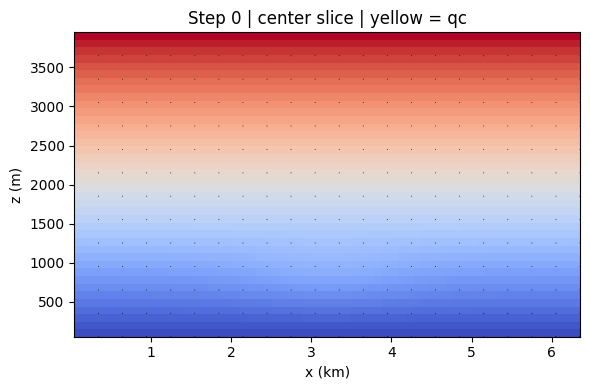

step   10: max qc = 0.000 g/kg | max w = 0.427 m/s | max θ' = 0.491 K


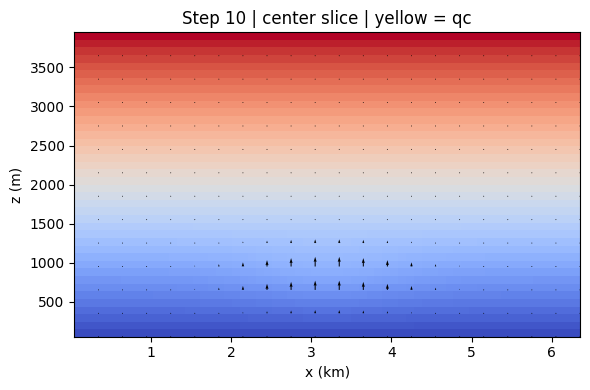

step   20: max qc = 0.000 g/kg | max w = 0.810 m/s | max θ' = 0.491 K


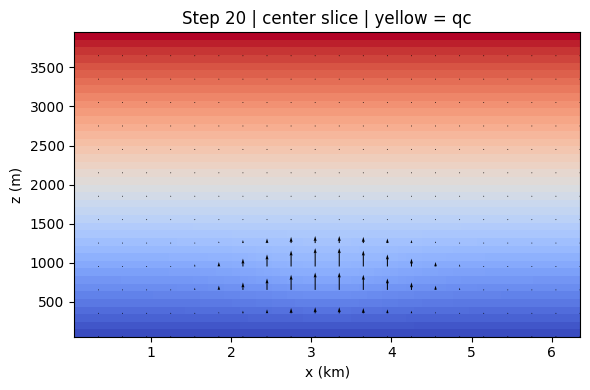

step   30: max qc = 0.000 g/kg | max w = 1.189 m/s | max θ' = 0.491 K


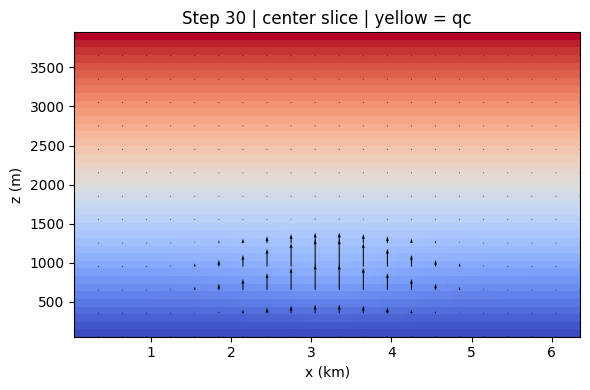

step   40: max qc = 0.000 g/kg | max w = 1.568 m/s | max θ' = 0.491 K


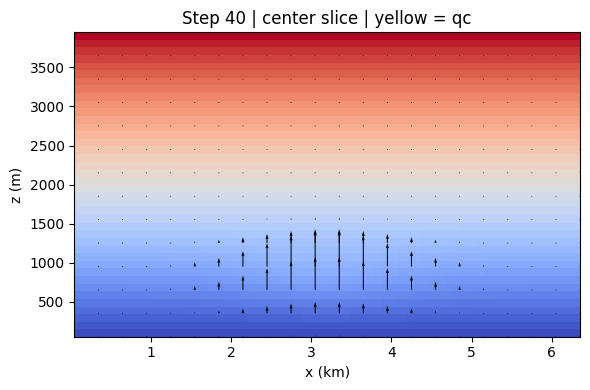

step   50: max qc = 0.000 g/kg | max w = 1.948 m/s | max θ' = 0.491 K


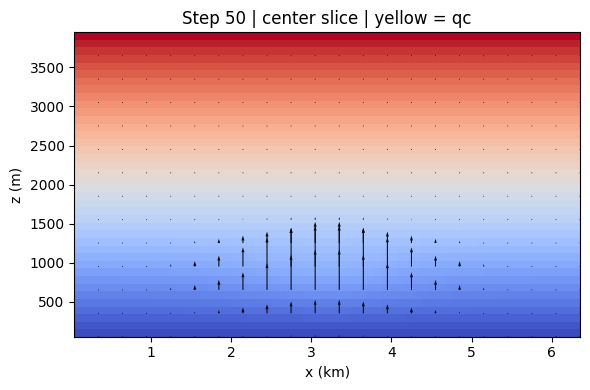

step   60: max qc = 0.000 g/kg | max w = 2.329 m/s | max θ' = 0.491 K


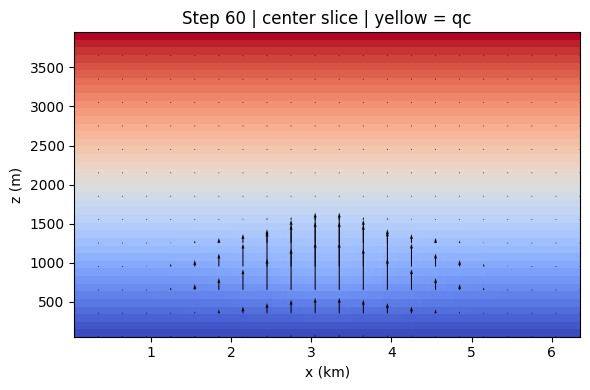

step   70: max qc = 0.000 g/kg | max w = 2.712 m/s | max θ' = 0.491 K


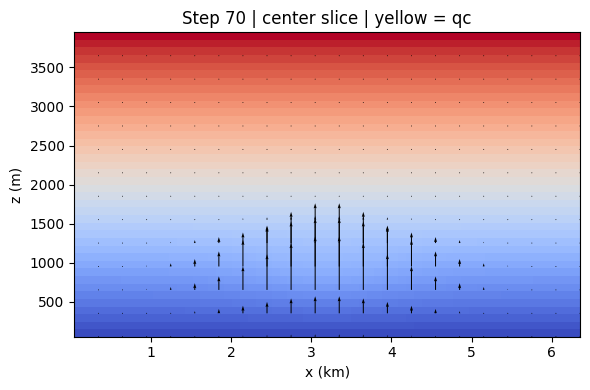

step   80: max qc = 0.000 g/kg | max w = 3.098 m/s | max θ' = 0.491 K


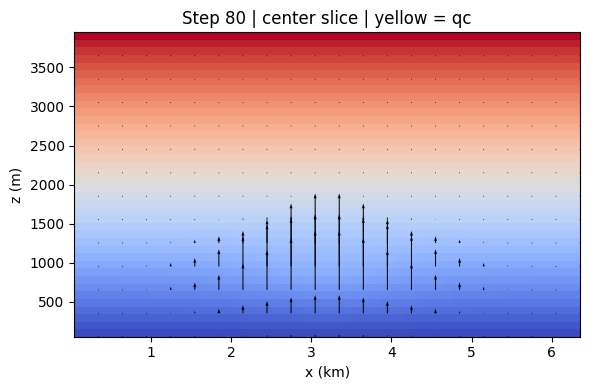

step   90: max qc = 0.000 g/kg | max w = 3.485 m/s | max θ' = 0.491 K


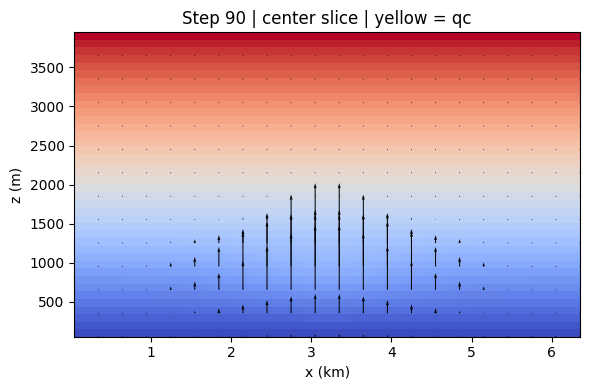

step  100: max qc = 0.000 g/kg | max w = 3.869 m/s | max θ' = 0.491 K


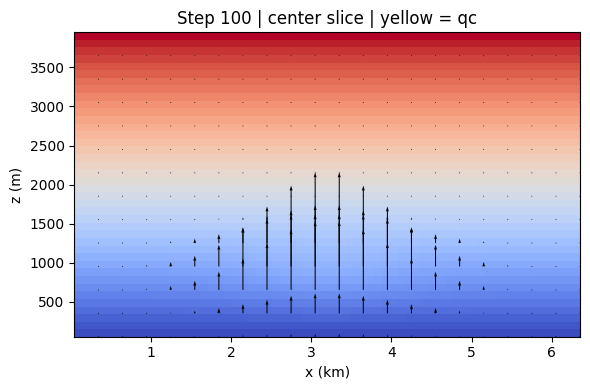

step  110: max qc = 0.000 g/kg | max w = 4.248 m/s | max θ' = 0.491 K


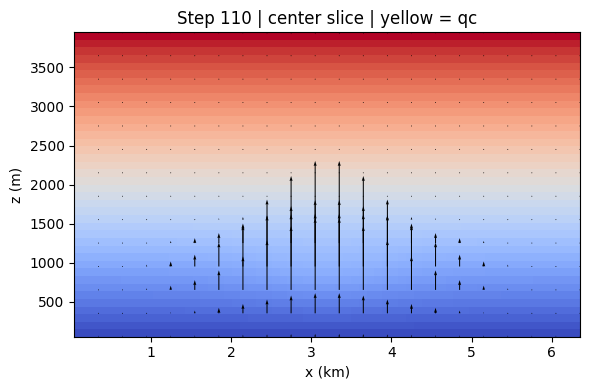

step  120: max qc = 0.000 g/kg | max w = 4.738 m/s | max θ' = 0.491 K


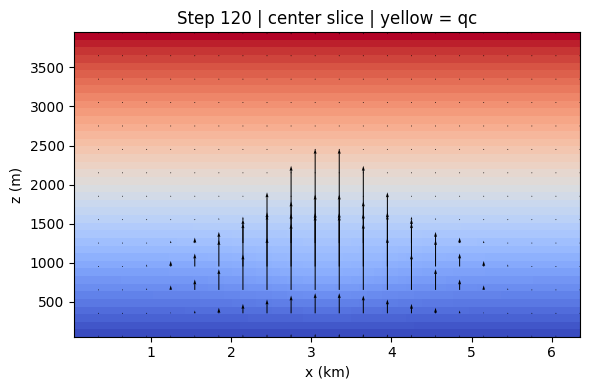

step  130: max qc = 0.000 g/kg | max w = 5.256 m/s | max θ' = 0.491 K


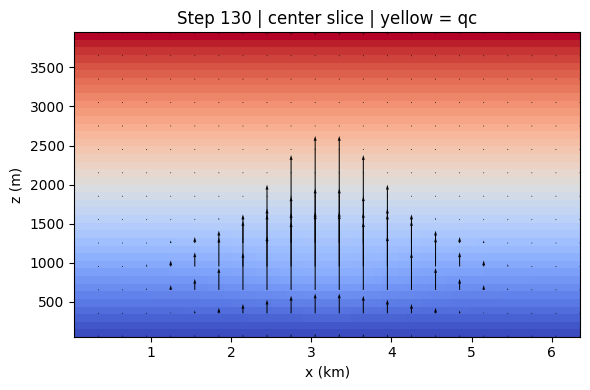

step  140: max qc = 0.000 g/kg | max w = 5.798 m/s | max θ' = 0.491 K


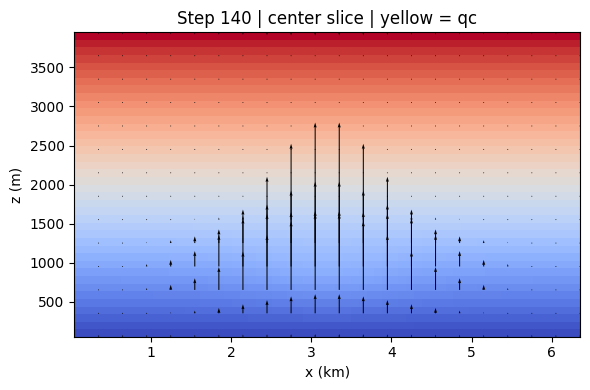

step  150: max qc = 0.000 g/kg | max w = 6.352 m/s | max θ' = 0.491 K


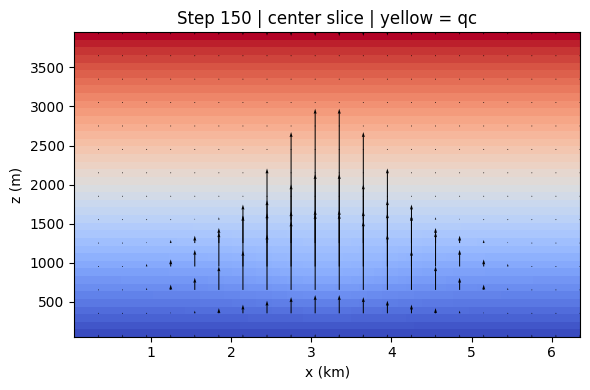

step  160: max qc = 0.000 g/kg | max w = 6.891 m/s | max θ' = 0.491 K


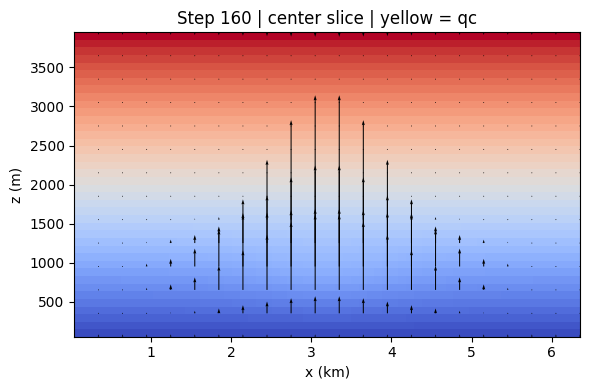

step  170: max qc = 0.000 g/kg | max w = 7.637 m/s | max θ' = 0.491 K


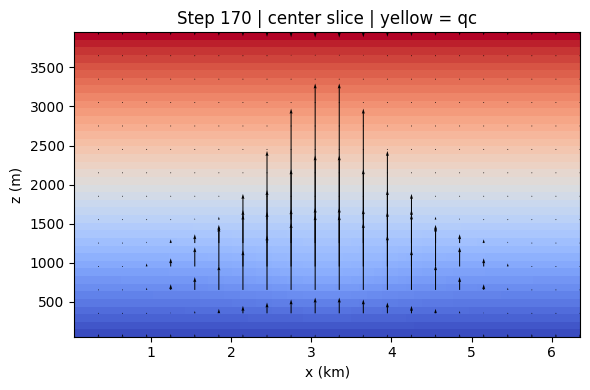

step  180: max qc = 0.000 g/kg | max w = 8.770 m/s | max θ' = 0.491 K


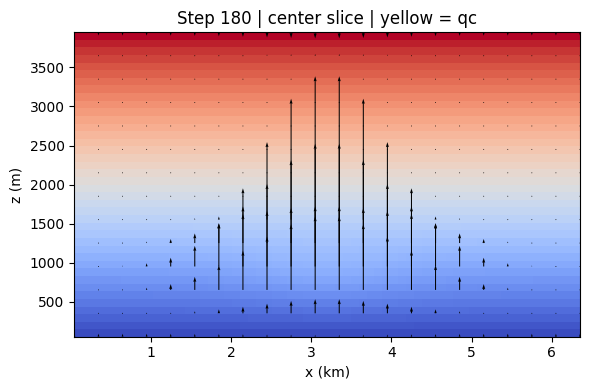

step  190: max qc = 0.000 g/kg | max w = 10.166 m/s | max θ' = 0.491 K


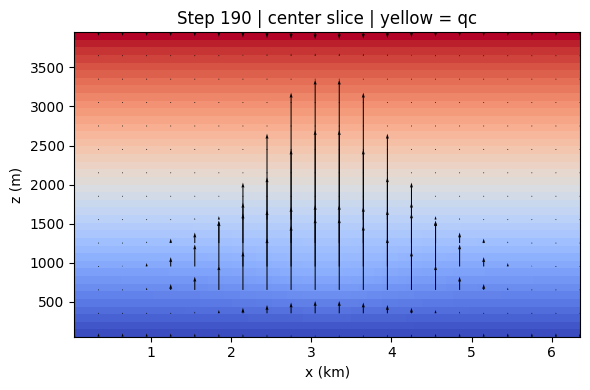

step  199: max qc = 0.000 g/kg | max w = 11.734 m/s | max θ' = 0.491 K


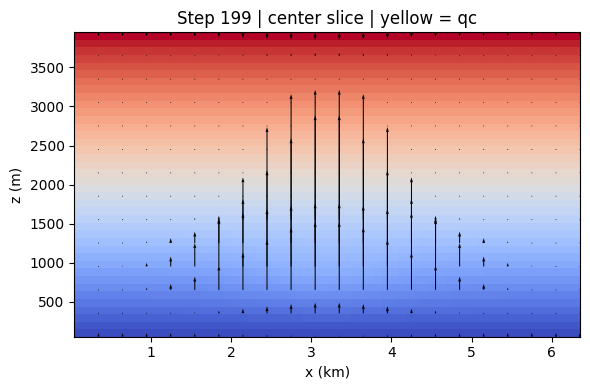


Summary: cells with cloud water > 0.0  | cells with upward motion > 143388.0


In [140]:
# # ------------------ Initialization that makes a small cloud ------------------
# nx, ny, nz = 64, 64, 40
# Lx, Ly, Lz = 6400.0, 6400.0, 4000.0   # 6.4 km × 6.4 km × 4 km
# dx, dy, dz = Lx/nx, Ly/ny, Lz/nz

# # Grid
# x = (np.arange(nx)+0.5)*dx
# y = (np.arange(ny)+0.5)*dy
# z = (np.arange(nz)+0.5)*dz
# X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# # --- Background thermodynamics ---
# theta0_surface = 300.0  # K
# dtheta0_dz = -0.0065    # K/m  (temperature decreases upward)
# theta0 = theta0_surface + dtheta0_dz * Z
# T0 = theta0.copy()      # treat as actual temperature here

# p0 = 1.0e5  # Pa

# # Saturation mixing ratio (same form as your microphysics)
# def qsat(T, p, eps=0.622):
#     es = 610.94 * np.exp(17.625*(T - 273.15)/(T - 30.11))  # Pa
#     return eps * es / (p - es)

# qs_bg = qsat(T0, p0)

# # Background relative humidity (~80%)
# RH_bg = 0.5
# qv_bg = RH_bg * qs_bg

# # # --- Warm, moist bubble (radius ~800 m) centered near 400 m height ---
# # xb, yb, zb = Lx*0.5, Ly*0.5, 400.0
# # rb = 800.0
# # r2 = (X - xb)**2 + (Y - yb)**2 + (Z - zb)**2
# # bubble = np.exp(-r2 / (2.0 * rb**2))

# # # Bubble is slightly warmer and closer to saturation
# # RH_bubble = 0.9
# # theta_p0 = 0.5 * bubble          # ~+0.5 K warm anomaly
# # qv0 = qv_bg + (RH_bubble * qs_bg - qv_bg) * bubble
# # --- Warm, moist bubble centered near 800 m, vertically compact ---
# xb, yb, zb = Lx*0.5, Ly*0.5, 800.0

# rb_xy = 800.0   # horizontal radius
# rb_z  = 300.0   # vertical radius (tighter)

# r2_xy = (X - xb)**2 + (Y - yb)**2
# r2_z  = (Z - zb)**2

# bubble = np.exp(-r2_xy / (2.0 * rb_xy**2) - r2_z / (2.0 * rb_z**2))
# bubble[Z < 2500.0] = 0.0


# RH_bubble = 0.9
# theta_p0 = 0.5 * bubble
# qv0 = qv_bg + (RH_bubble * qs_bg - qv_bg) * bubble

# # --- Zero initial motion, no cloud water ---
# u0 = np.zeros_like(theta0)
# v0 = np.zeros_like(theta0)
# w0 = np.zeros_like(theta0)
# qc0 = np.zeros_like(theta0)
# pi0 = np.zeros_like(theta0)

# state = {
#     'u': u0, 'v': v0, 'w': w0,
#     'theta_p': theta_p0,
#     'qv': qv0, 'qc': qc0, 'pi': pi0
# }

# params = {
#     'dx': dx, 'dy': dy, 'dz': dz,
#     'theta0': theta0,
#     'dtheta0_dz': np.full_like(theta0, dtheta0_dz),
#     'p0': p0,
#     'Lv': 2.5e6, 'cp': 1004.0, 'R': 287.0,
#     'p_ref': 1.0e5, 'eps': 0.622,
#     'g': 9.81
# }
nx, ny, nz = 64, 64, 40
Lx, Ly, Lz = 6400.0, 6400.0, 4000.0
dx, dy, dz = Lx/nx, Ly/ny, Lz/nz

x = (np.arange(nx)+0.5)*dx
y = (np.arange(ny)+0.5)*dy
z = (np.arange(nz)+0.5)*dz
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# --- Background potential temperature θ0(z): stable, increases with height ---
theta0_surface = 300.0      # K
dtheta0_dz = 0.003          # K/m  (3 K/km)
theta0 = theta0_surface + dtheta0_dz * Z

# For simplicity: Boussinesq with constant base pressure
p0 = 1.0e5                  # Pa
Pi0 = exner(p0, p_ref=1.0e5, R=287.0, cp=1004.0)
T0 = theta0 * Pi0           # treat this as actual T for qsat

def qsat(T, p, eps=0.622):
    es = 610.94 * np.exp(17.625*(T - 273.15)/(T - 30.11))
    es = np.minimum(es, 0.99*p)
    return eps * es / (p - es)

qs_bg = qsat(T0, p0)
RH_bg = 0.5
qv_bg = RH_bg * qs_bg

# --- Warm, moist bubble (small perturbation) ---
xb, yb, zb = Lx*0.5, Ly*0.5, 800.0
rb_xy = 800.0
rb_z  = 300.0

r2_xy = (X - xb)**2 + (Y - yb)**2
r2_z  = (Z - zb)**2
bubble = np.exp(-r2_xy/(2.0*rb_xy**2) - r2_z/(2.0*rb_z**2))

theta_p0 = 0.5 * bubble                         # +0.5 K anomaly
RH_bubble = 0.9
qv_target = RH_bubble * qs_bg
qv0 = qv_bg + (qv_target - qv_bg) * bubble      # moister in bubble
qv0 = np.maximum(qv0, 0.0)
qc0 = np.zeros_like(theta0)

# Conserved moist variables:
#   qt = qv + qc
#   θ_l = θ - (Lv/(cp*Pi))*qc  (here qc=0 so θ_l = θ)
Lv = 2.5e6
cp = 1004.0

theta_init = theta0 + theta_p0
theta_l0 = theta_init.copy()                    # qc=0, so θ_l = θ
qt0 = qv0 + qc0

u0 = np.zeros_like(theta0)
v0 = np.zeros_like(theta0)
w0 = np.zeros_like(theta0)
pi0 = np.zeros_like(theta0)

state = {
    'u': u0, 'v': v0, 'w': w0,
    'theta_l': theta_l0,
    'qt': qt0,
    'qc': qc0,
    # diagnostics (will be overwritten each step)
    'theta_p': theta_p0,
    'qv': qv0,
    'pi': pi0,
}

params = {
    'dx': dx, 'dy': dy, 'dz': dz,
    'theta0': theta0,
    'dtheta0_dz': np.full_like(theta0, dtheta0_dz),
    'p0': p0,
    'Lv': Lv, 'cp': cp, 'R': 287.0,
    'p_ref': 1.0e5, 'eps': 0.622,
    'g': 9.81,
    'nu': 30.0,   # mild viscosity
    'kappa': 5.0,
    'Dq': 5.0,
    'tau_damp_w': 300.0,
    'qv0': qv_bg.copy()
}

# --- quick diagnostic to verify no initial supersaturation ---
T_init = T0 + theta_p0
qs_init = qsat(T_init, p0)
print("max(qv - qs) at t=0:", np.max(qv0 - qs_init))


# --- run a short integration: buoyancy + microphysics only ---
dt = 0.01  # seconds (tiny, safe)
steps = 200

def diag(state, step):
    qc_max = state['qc'].max()
    w_max  = state['w'].max()
    thp_max= state['theta_p'].max()
    print(f"step {step:4d}: max qc = {qc_max*1000:.3f} g/kg | max w = {w_max:.3f} m/s | max θ' = {thp_max:.3f} K")

print("Running... (expect qc to flip on near the bubble as it lifts, w to grow)")
plt.figure()
for n in range(steps):
    dt = compute_dt(state, params, cfl=0.4)
    state = step_rk2(state, dt, params)
    if n % 10 == 0 or n == steps-1:
        diag(state, n)
        plot_state(state, n, params)

# Provide simple summaries for quick confirmation
qc_any = float((state['qc']>0).sum())
wpos = float((state['w']>0).sum())
print("\nSummary: cells with cloud water >", qc_any, " | cells with upward motion >", wpos)


In [10]:
# # -----------------
# # Tests (from user)
# # -----------------
# def test_hot_cell_diffusion_scalar():
#     nx, ny, nz = 16, 16, 16
#     dx = dy = dz = 1.0
#     kappa = 0.5

#     phi = np.zeros((nx, ny, nz), dtype=np.float64)
#     phi[nx//2, ny//2, nz//2] = 1.0  # single hot cell

#     rhs = diffuse_scalar(phi, kappa, dx, dy, dz)

#     center = rhs[nx//2, ny//2, nz//2]
#     # center should cool -> negative tendency
#     center_sign_ok = center < 0.0

#     # one neighbor should warm -> positive tendency
#     neighbor = rhs[(nx//2)+1, ny//2, nz//2]
#     neighbor_sign_ok = neighbor > 0.0

#     # energy (variance) dissipation check: sum(phi * rhs) <= 0
#     energy_rate = np.sum(phi * rhs)
#     dissipation_ok = energy_rate <= 1e-12  # allow tiny numerical noise

#     return center_sign_ok, neighbor_sign_ok, dissipation_ok, phi, rhs

# def test_rk2_diffusion_decay():
#     nx, ny, nz = 16, 16, 16
#     dx = dy = dz = 1.0
#     nu = 0.2
#     kappa = 0.4
#     Dq = 0.4

#     rng = np.random.default_rng(0)
#     state = {
#         'u': rng.normal(size=(nx, ny, nz)),
#         'v': rng.normal(size=(nx, ny, nz)),
#         'w': rng.normal(size=(nx, ny, nz)),
#         'theta_p': rng.normal(size=(nx, ny, nz)),
#         'qv': rng.normal(size=(nx, ny, nz)),
#         'qc': rng.normal(size=(nx, ny, nz)),
#         'pi': np.zeros((nx, ny, nz))
#     }

#     params = dict(dx=dx, dy=dy, dz=dz, nu=nu, kappa=kappa, Dq=Dq, enable_diffusion=True)
#     dt = 0.1

#     # compute norms before
#     def norm2(s):
#         return (
#             np.linalg.norm(s['u'])**2 +
#             np.linalg.norm(s['v'])**2 +
#             np.linalg.norm(s['w'])**2 +
#             np.linalg.norm(s['theta_p'])**2 +
#             np.linalg.norm(s['qv'])**2 +
#             np.linalg.norm(s['qc'])**2
#         )

#     e0 = norm2(state)
#     state_new = step_rk2(state, dt, params)
#     e1 = norm2(state_new)

#     return e1 < e0, state, state_new

# # -----------------
# # Run tests + print
# # -----------------
# c_ok, n_ok, d_ok, phi0, rhs0 = test_hot_cell_diffusion_scalar()
# rk_ok, state_before, state_after = test_rk2_diffusion_decay()

# print("Test A (hot cell) center cools:", "PASS" if c_ok else "FAIL")
# print("Test A (hot cell) neighbor warms:", "PASS" if n_ok else "FAIL")
# print("Test A (hot cell) dissipative energy:", "PASS" if d_ok else "FAIL")
# print("Test B (RK2 with diffusion only) norms decay:", "PASS" if rk_ok else "FAIL")

# # -----------------
# # Plots for visual intuition
# # -----------------
# # 1) Simple hot-cell diffusion: show middle-z slice initially, and after N Euler steps
# nx, ny, nz = phi0.shape
# mid_k = nz // 2
# phi_initial_slice = phi0[:, :, mid_k]

# # evolve a copy a few explicit steps to illustrate dissipation visually
# dt_vis = 0.1
# steps_vis = 12
# phi_vis = phi0.copy()
# for _ in range(steps_vis):
#     rhs = diffuse_scalar(phi_vis, kappa=0.5, dx=1.0, dy=1.0, dz=1.0)
#     phi_vis = phi_vis + dt_vis * rhs

# phi_after_slice = phi_vis[:, :, mid_k]

# # Figure 1: Initial slice
# plt.figure()
# plt.title("Hot-cell diffusion: initial (middle-z slice)")
# plt.imshow(phi_initial_slice, origin='lower')
# plt.colorbar()
# plt.show()

# # Figure 2: After diffusion steps
# plt.figure()
# plt.title(f"Hot-cell diffusion: after {steps_vis} steps (middle-z slice)")
# plt.imshow(phi_after_slice, origin='lower')
# plt.colorbar()
# plt.show()


In [11]:
# def test_advection_constant_field_zero_rhs():
#     nx, ny, nz = 16, 16, 16
#     dx = dy = dz = 1.0
#     # constant scalar, arbitrary velocity
#     phi = np.ones((nx,ny,nz))
#     u = np.ones((nx,ny,nz))*0.7
#     v = np.ones((nx,ny,nz))*(-0.3)
#     w = np.ones((nx,ny,nz))*0.1
#     rhs = advect_scalar(phi, u, v, w, dx, dy, dz)
#     return np.allclose(rhs, 0.0, atol=1e-12)

# def test_advection_flux_conservation():
#     nx, ny, nz = 32, 16, 8
#     dx = dy = dz = 1.0
#     # Gaussian-ish blob + uniform wind in +x
#     x = np.arange(nx); y = np.arange(ny); z = np.arange(nz)
#     X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
#     cx, cy, cz = nx//2, ny//2, nz//2
#     r2 = (X-cx)**2 + (Y-cy)**2 + (Z-cz)**2
#     phi = np.exp(-r2/(2.0*4.0**2))

#     u = np.ones_like(phi) * 1.0
#     v = np.zeros_like(phi)
#     w = np.zeros_like(phi)

#     rhs = advect_scalar(phi, u, v, w, dx, dy, dz)

#     # Integral of RHS should be ~0 (periodic conservative form)
#     total = np.sum(rhs)
#     return abs(total) < 1e-9

# def test_velocity_advection_symmetry():
#     nx, ny, nz = 16, 16, 16
#     dx = dy = dz = 1.0
#     # Build a simple shear flow and check advection doesn't return all zeros
#     x = np.arange(nx)[:,None,None]
#     u = x.repeat(ny,1).repeat(nz,2).astype(float)  # u increases with x
#     v = np.zeros_like(u)
#     w = np.zeros_like(u)
#     rhs_u, rhs_v, rhs_w = advect_velocity(u, v, w, dx, dy, dz)
#     # We expect some non-zero tendency in rhs_u due to ∂(u^2)/∂x term; v,w should be zero
#     return (np.any(np.abs(rhs_u) > 0) and np.allclose(rhs_v, 0.0) and np.allclose(rhs_w, 0.0))

# print("Advection test: constant field gives zero RHS:", "PASS" if test_advection_constant_field_zero_rhs() else "FAIL")
# print("Advection test: integral conservation (periodic):", "PASS" if test_advection_flux_conservation() else "FAIL")
# print("Velocity advection basic sanity:", "PASS" if test_velocity_advection_symmetry() else "FAIL")

In [12]:
# # Buoyancy & theta-tendency visualizations built on your tests.
# # - Does NOT modify `compute_buoyancy` or `theta_rhs_extra`.
# # - Adds plots to verify visually:
# #   (1) Warm blob -> positive buoyancy and upward motion.
# #   (2) qv raises buoyancy, qc lowers it (bar chart of mean Δb).
# #   (3) Ascent cools: apply theta_rhs_extra with upward w over a few RK2 steps,
# #       showing θ′ becoming negative where air rises.
# #
# # Assumptions: `compute_buoyancy(theta_p, qv, qc, theta0, g)` and
# # `theta_rhs_extra(w, dthdz)` are defined in your environment.

# import numpy as np
# import matplotlib.pyplot as plt

# # ----------------- Your tests (kept functionally intact) -----------------

# def test_buoyancy_constant_theta_prime():
#     nx, ny, nz = 8, 8, 8
#     theta_p = np.ones((nx,ny,nz), dtype=float)  # +1 K everywhere
#     qv = np.zeros_like(theta_p)                 # 0
#     qc = np.zeros_like(theta_p)                 # 0
#     theta0 = np.ones_like(theta_p) * 300.0      # 300 K background
#     g = 9.81
#     b = compute_buoyancy(theta_p, qv, qc, theta0, g)
#     expected = g * (1.0 / 300.0)                # ≈ 0.0327 m/s^2
#     return np.allclose(b, expected), b.mean(), expected, b

# def test_buoyancy_qv_qc_effects():
#     nx, ny, nz = 16, 16, 16
#     theta_p = np.zeros((nx,ny,nz))
#     theta0  = np.ones_like(theta_p) * 300.0
#     g = 9.81
#     b0  = compute_buoyancy(theta_p, np.zeros_like(theta_p), np.zeros_like(theta_p), theta0, g)
#     b_qv = compute_buoyancy(theta_p, np.ones_like(theta_p)*0.002, np.zeros_like(theta_p), theta0, g)
#     b_qc = compute_buoyancy(theta_p, np.zeros_like(theta_p), np.ones_like(theta_p)*0.002, theta0, g)
#     delta_qv = (b_qv - b0).mean()
#     delta_qc = (b_qc - b0).mean()
#     return (delta_qv > 0) and (delta_qc < 0), delta_qv, delta_qc, (b0, b_qv, b_qc)

# def test_theta_rhs_extra_signs():
#     nx, ny, nz = 6, 6, 6
#     w = np.ones((nx,ny,nz)) * 2.0         # upward motion
#     dthdz = np.ones_like(w) * 0.003       # stable stratification (3 K/km ~ 0.003 K/m here as toy)
#     rhs1 = theta_rhs_extra(w, dthdz)      # expect negative
#     cond1 = np.all(rhs1 < 0.0)
#     rhs2 = theta_rhs_extra(-w, dthdz)     # downward -> expect positive
#     cond2 = np.all(rhs2 > 0.0)
#     rhs3 = theta_rhs_extra(w, -dthdz)     # unstable -> upward warms
#     cond3 = np.all(rhs3 > 0.0)
#     return cond1 and cond2 and cond3, (rhs1.mean(), rhs2.mean(), rhs3.mean())

# # ----------------- Run tests & print status -----------------
# ok_buoy, mean_b, exp_b, b_field = test_buoyancy_constant_theta_prime()
# print("Buoyancy test (θ'=+1K, qv=qc=0):",
#           "PASS" if ok_buoy else "FAIL", "| mean b =", mean_b, " expected ≈", exp_b)

# ok_q, dqv, dqc, b_pack = test_buoyancy_qv_qc_effects()
# print("Buoyancy test (qv up -> b up, qc up -> b down):",
#           "PASS" if ok_q else "FAIL", "| Δb_qv =", dqv, ", Δb_qc =", dqc)

# ok_t, means = test_theta_rhs_extra_signs()
# print("Theta RHS extra sign checks:", "PASS" if ok_t else "FAIL", "| means =", means)

# # (1) Warm air rising: make a warm blob, compute buoyancy, show x–z slice + vectors indicating upward

# # Build a non-uniform θ′ so the pattern is visible (Gaussian warm blob low in the domain)
# nx, ny, nz = 64, 32, 32
# x = np.arange(nx); y = np.arange(ny); z = np.arange(nz)
# X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
# cx, cy, cz = nx//3, ny//2, nz//4
# r2 = ((X-cx)**2 + (Y-cy)**2 + (Z-cz)**2)
# theta_p = 2.0 * np.exp(-r2/(2.0*6.0**2))  # +2 K warm blob
# qv = np.zeros_like(theta_p)
# qc = np.zeros_like(theta_p)
# theta0 = np.ones_like(theta_p) * 300.0
# g = 9.81
# b = compute_buoyancy(theta_p, qv, qc, theta0, g)

# # x–z slice through center-y
# jmid = ny//2
# thetap_xz = theta_p[:, jmid, :].T  # shape (nz, nx) after transpose for imshow coords
# b_xz      = b[:, jmid, :].T

# plt.figure()
# plt.title("Warm blob → positive buoyancy (x–z slice at mid-y)")
# plt.imshow(thetap_xz, origin='lower', extent=[0,nx,0,nz], aspect='auto')
# plt.colorbar(label="θ′ (K)")
# # Overplot buoyancy-driven 'w-proxy' arrows (scaled b)
# # Use a coarse grid of arrows to keep it readable
# skip = 4
# xs = np.arange(0, nx, skip) + 0.5*skip
# zs = np.arange(0, nz, skip) + 0.5*skip
# XS, ZS = np.meshgrid(xs, zs, indexing='xy')
# # pull b on that grid
# b_sample = b_xz[(ZS.clip(0,nz-1)).astype(int), (XS.clip(0,nx-1)).astype(int)]
# u0 = np.zeros_like(b_sample)  # horizontal not from buoyancy; just show vertical push
# w0 = b_sample / np.nanmax(np.abs(b_sample)+1e-12) * 2.0  # scale for visibility
# plt.quiver(XS, ZS, u0, w0, angles='xy', scale_units='xy', scale=1)
# plt.xlabel('x index'); plt.ylabel('z index')
# plt.show()

# # (3) As air rises it cools: integrate θ′ using theta_rhs_extra with a prescribed updraft
# # domain & fields
# nx, ny, nz = 64, 32, 32
# x = np.arange(nx); y = np.arange(ny); z = np.arange(nz)
# X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
# jmid = ny//2

# # Updraft w: a tall Gaussian column
# wx = 2.0 * np.exp(-((X-nx//2)**2 + (Y-jmid)**2)/(2.0*8.0**2))
# w = wx * np.exp(-((Z - nz//2)**2)/(2.0*10.0**2))

# # Background stratification (stable): dθ/dz > 0.
# # Represented here as constant in space for the test.
# dthdz = np.ones_like(w) * 0.003  # K per model-level (toy)

# # Start from θ′ = 0 and evolve with θ′_t = theta_rhs_extra(w, dthdz)
# def theta_rhs(theta_p):
#     # theta_rhs_extra ignores theta_p here; included to match a RHS signature
#     return theta_rhs_extra(w, dthdz)

# def rk2_step(theta_p, dt):
#     k1 = theta_rhs(theta_p)
#     k2 = theta_rhs(theta_p + 0.5*dt*k1)
#     return theta_p + dt*k2

# theta_p0 = np.zeros((nx,ny,nz), dtype=float)
# theta_pN = theta_p0.copy()
# dt = 1.0
# steps = 20
# for _ in range(steps):
#     theta_pN = rk2_step(theta_pN, dt)

# # Plot initial vs final θ′ on x–z slice at mid-y
# plt.figure()
# plt.title("Ascent cools: θ′ initial (x–z slice at mid-y)")
# plt.imshow(theta_p0[:, jmid, :].T, origin='lower', extent=[0,nx,0,nz], aspect='auto')
# plt.colorbar(label="θ′ (K)")
# plt.xlabel('x index'); plt.ylabel('z index')
# plt.show()

# plt.figure()
# plt.title(f"Ascent cools: θ′ after {steps} steps (x–z slice at mid-y)")
# plt.imshow(theta_pN[:, jmid, :].T, origin='lower', extent=[0,nx,0,nz], aspect='auto')
# plt.colorbar(label="θ′ (K)")
# plt.xlabel('x index'); plt.ylabel('z index')
# plt.show()

# # For additional intuition, show w on the same slice
# plt.figure()
# plt.title("Prescribed updraft w (x–z slice at mid-y)")
# plt.imshow(w[:, jmid, :].T, origin='lower', extent=[0,nx,0,nz], aspect='auto')
# plt.colorbar(label="w (arbitrary units)")
# plt.xlabel('x index'); plt.ylabel('z index')
# plt.show()


In [13]:
# # -----------------
# # Tiny smoke test
# # -----------------
# # Make a small dummy state; with zero RHS & identity projection,
# # the state should not change after one RK2 step.
# nx, ny, nz = 8, 8, 8
# rng = np.random.default_rng(42)
# state0 = {
#     'u': rng.normal(size=(nx, ny, nz)).astype(np.float64),
#     'v': rng.normal(size=(nx, ny, nz)).astype(np.float64),
#     'w': rng.normal(size=(nx, ny, nz)).astype(np.float64),
#     'theta_p': rng.normal(size=(nx, ny, nz)).astype(np.float64),
#     'qv': rng.normal(size=(nx, ny, nz)).astype(np.float64),
#     'qc': rng.normal(size=(nx, ny, nz)).astype(np.float64),
#     'pi': np.zeros((nx, ny, nz), dtype=np.float64),
# }
# dt = 0.5

# state1 = step_rk2(state0, dt)

# # Verify unchanged
# # unchanged = (
# #     np.allclose(state0['u'], state1['u']) and
# #     np.allclose(state0['v'], state1['v']) and
# #     np.allclose(state0['w'], state1['w']) and
# #     np.allclose(state0['theta_p'], state1['theta_p']) and
# #     np.allclose(state0['qv'], state1['qv']) and
# #     np.allclose(state0['qc'], state1['qc'])
# # )

# # print("RK2 scaffold smoke test (zero RHS, identity projection):", "PASS" if unchanged else "FAIL")

In [14]:
# # --- Test utilities ---
# def find_T_for_target_qs(p, q_target, T_lo=260.0, T_hi=310.0, iters=40):
#     """
#     Bisection on T (K) to find T such that qs(T,p) ≈ q_target (kg/kg).
#     """
#     lo, hi = T_lo, T_hi
#     for _ in range(iters):
#         mid = 0.5 * (lo + hi)
#         qs_mid = saturation_mixing_ratio(mid, p)
#         if qs_mid < q_target:
#             lo = mid
#         else:
#             hi = mid
#     return 0.5 * (lo + hi)

# # --- Tests ---
# def test_single_cell_condensation_and_evaporation():
#     # Setup: choose p, then T so that qs = 0.010 kg/kg (10 g/kg)
#     p0 = 1.0e5  # Pa
#     q_target = 0.010
#     T_star = find_T_for_target_qs(p0, q_target)  # K

#     # Background state
#     theta0 = 300.0  # K
#     Pi = exner(p0)
#     theta_needed = T_star / Pi
#     theta_p0 = theta_needed - theta0  # so that (theta0+theta_p0)*Pi = T_star
#     Lv, cp = 2.5e6, 1004.0

#     # --- Case 1: condensation (qv > qs) ---
#     theta_p = np.array(theta_p0, dtype=float)
#     qv = np.array(q_target + 0.002, dtype=float)  # 12 g/kg
#     qc = np.array(0.0, dtype=float)

#     theta_p, qv, qc = microphysics_saturation_adjust(theta_p, qv, qc, theta0, p0, Lv=Lv, cp=cp)

#     # Expected: qv -> 0.010, qc -> 0.002, theta_p increases by (Lv/(cp*Pi))*0.002
#     expected_qv = q_target
#     expected_qc = 0.002
#     expected_dtheta = (Lv / (cp * Pi)) * expected_qc

#     cond_ok = (
#         abs(qv - expected_qv) < 5e-7 and
#         abs(qc - expected_qc) < 5e-7 and
#         abs((theta_p - theta_p0) - expected_dtheta) < 5e-5  # slightly looser due to one-pass approx
#     )

#     # --- Case 2: evaporation (qv < qs, qc available) ---
#     theta_p = np.array(theta_p0, dtype=float)
#     qv = np.array(q_target - 0.002, dtype=float)  # 8 g/kg
#     qc = np.array(0.002, dtype=float)            # 2 g/kg available to evaporate

#     theta_p, qv, qc = microphysics_saturation_adjust(theta_p, qv, qc, theta0, p0, Lv=Lv, cp=cp)

#     # Expected: qv -> 0.010, qc -> 0.000, theta_p decreases by same magnitude as above
#     evap_ok = (
#         abs(qv - expected_qv) < 5e-7 and
#         abs(qc - 0.0) < 5e-7 and
#         abs((theta_p - theta_p0) + expected_dtheta) < 5e-5
#     )

#     return cond_ok, evap_ok, {
#         "T_star_K": T_star,
#         "Pi": Pi,
#         "expected_dtheta": expected_dtheta
#     }

# def test_broadcast_array():
#     # Small 3D array where half cells condense, half evaporate
#     nx, ny, nz = 4, 4, 4
#     p0 = 90000.0  # Pa (slightly lower pressure aloft)
#     q_target = 0.010
#     T_star = find_T_for_target_qs(p0, q_target)
#     theta0 = 300.0
#     Pi = exner(p0)
#     theta_p0 = (T_star / Pi) - theta0

#     theta_p = np.full((nx,ny,nz), theta_p0, dtype=float)
#     qv = np.full((nx,ny,nz), q_target, dtype=float)
#     qc = np.zeros((nx,ny,nz), dtype=float)

#     # make half supersaturated (+0.002), half sub-saturated with qc=0.002
#     mask = np.zeros((nx,ny,nz), dtype=bool)
#     mask[:nx//2,:,:] = True
#     qv[mask] += 0.002       # condense
#     qv[~mask] -= 0.002      # evaporate side
#     qc[~mask] = 0.002

#     theta_p, qv, qc = microphysics_saturation_adjust(theta_p, qv, qc, theta0, p0)

#     ok_cond = np.allclose(qv[mask], q_target, atol=1e-6) and np.allclose(qc[mask], 0.002, atol=1e-6)
#     ok_evap = np.allclose(qv[~mask], q_target, atol=1e-6) and np.allclose(qc[~mask], 0.0, atol=1e-6)
#     return ok_cond and ok_evap

# # Run tests
# ok1, ok2, info = test_single_cell_condensation_and_evaporation()
# ok3 = test_broadcast_array()

# print("Single-cell condensation test:", "PASS" if ok1 else "FAIL")
# print("Single-cell evaporation test:", "PASS" if ok2 else "FAIL")
# print("Broadcast 3D adjust test:", "PASS" if ok3 else "FAIL")
# print("Info:", info)

In [15]:
# # ---- Helpers for diagnostics ----
# def periodic_divergence(u, v, w, dx, dy, dz):
#     """Centered finite-difference divergence with periodic wrap."""
#     dudx = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2*dx)
#     dvdy = (np.roll(v, -1, axis=1) - np.roll(v, 1, axis=1)) / (2*dy)
#     dwdz = (np.roll(w, -1, axis=2) - np.roll(w, 1, axis=2)) / (2*dz)
#     return dudx + dvdy + dwdz

# def kinetic_energy(u, v, w):
#     return 0.5 * np.mean(u*u + v*v + w*w)

# # ---- Test 1: gradient-only field (should be removed by projection) ----
# def test_gradient_only():
#     nx, ny, nz = 48, 32, 24
#     Lx, Ly, Lz = 1.0, 1.0, 1.0
#     dx, dy, dz = Lx/nx, Ly/ny, Lz/nz
#     x = np.linspace(0, Lx, nx, endpoint=False)[:, None, None]
#     u = np.sin(2*np.pi*3*x)  # kx=3 mode
#     v = np.zeros_like(u)
#     w = np.zeros_like(u)

#     div0 = periodic_divergence(u, v, w, dx, dy, dz)
#     div0_norm = np.linalg.norm(div0)

#     u2, v2, w2, psi = project_velocity_fft(u, v, w, dx, dy, dz)

#     div1 = periodic_divergence(u2, v2, w2, dx, dy, dz)
#     div1_norm = np.linalg.norm(div1)

#     ke0 = kinetic_energy(u, v, w)
#     ke1 = kinetic_energy(u2, v2, w2)

#     return {
#         "div_norm_before": div0_norm,
#         "div_norm_after": div1_norm,
#         "div_reduction_factor": div0_norm / max(div1_norm, 1e-30),
#         "ke_before": ke0,
#         "ke_after": ke1
#     }

# # ---- Test 2: nearly divergence-free field (projection small change) ----
# def test_div_free_field_energy_preserved():
#     nx, ny, nz = 48, 32, 24
#     Lx, Ly, Lz = 1.0, 1.0, 1.0
#     dx, dy, dz = Lx/nx, Ly/ny, Lz/nz

#     # Stream function psi_s so that u =  d(psi_s)/dy, v = -d(psi_s)/dx, w = 0 => div≈0
#     x = np.linspace(0, Lx, nx, endpoint=False)[:, None, None]
#     y = np.linspace(0, Ly, 1, endpoint=False)[None, :, None]  # size 1 to broadcast dy derivative cleanly
#     # Use full grids to avoid broadcasting confusion
#     xg = np.linspace(0, Lx, nx, endpoint=False)[:, None, None]
#     yg = np.linspace(0, Ly, ny, endpoint=False)[None, :, None]
#     zg = np.linspace(0, Lz, nz, endpoint=False)[None, None, :]

#     psi_s = np.sin(2*np.pi*2*xg) * np.cos(2*np.pi*3*yg)
#     # finite differences for periodic derivatives
#     dpsidy = (np.roll(psi_s, -1, axis=1) - np.roll(psi_s, 1, axis=1)) / (2*dy)
#     dpsidx = (np.roll(psi_s, -1, axis=0) - np.roll(psi_s, 1, axis=0)) / (2*dx)

#     u =  dpsidy
#     v = -dpsidx
#     w = np.zeros_like(psi_s)

#     div0 = periodic_divergence(u, v, w, dx, dy, dz)
#     div0_norm = np.linalg.norm(div0)

#     u2, v2, w2, _ = project_velocity_fft(u, v, w, dx, dy, dz)

#     div1 = periodic_divergence(u2, v2, w2, dx, dy, dz)
#     div1_norm = np.linalg.norm(div1)

#     ke0 = kinetic_energy(u, v, w)
#     ke1 = kinetic_energy(u2, v2, w2)

#     ke_change = abs(ke1 - ke0) / max(ke0, 1e-30)

#     return {
#         "div_norm_before": div0_norm,
#         "div_norm_after": div1_norm,
#         "div_reduction_factor": (div0_norm / max(div1_norm, 1e-30)) if div1_norm>0 else np.inf,
#         "rel_ke_change": ke_change
#     }

# # Run tests
# res1 = test_gradient_only()
# res2 = test_div_free_field_energy_preserved()

# print("Test 1 (gradient-only):")
# for k, v in res1.items():
#     print(f"  {k}: {v:.3e}")
# print("\nTest 2 (divergence-free energy preservation):")
# for k, v in res2.items():
#     print(f"  {k}: {v:.3e}")

In [91]:
# def compute_dt(state, params, cfl=0.4):
#     dx_min = min(params['dx'], params['dy'], params['dz'])
#     umax = max(
#         1.0,  # floor so dt doesn’t explode at t=0
#         float(np.abs(state['u']).max()),
#         float(np.abs(state['v']).max()),
#         float(np.abs(state['w']).max()),
#     )
#     return min(params.get('dt_max', 1.0), cfl * dx_min / umax)
def compute_dt(state, params, cfl=0.4, dt_max=0.5):
    """
    Very safe dt:
      - CFL-limited by advection
      - optionally limited by diffusion
      - hard-capped by dt_max
    """
    dx, dy, dz = params['dx'], params['dy'], params['dz']
    u = state['u']; v = state['v']; w = state['w']

    # advective speeds
    max_u = float(np.max(np.abs(u)))
    max_v = float(np.max(np.abs(v)))
    max_w = float(np.max(np.abs(w)))

    # avoid divide-by-zero: if flow is still, use a big dummy denominator
    max_vel_over_space = max(
        max_u / dx if max_u > 0 else 0.0,
        max_v / dy if max_v > 0 else 0.0,
        max_w / dz if max_w > 0 else 0.0,
        1e-8,  # don't let this go to 0
    )
    dt_adv = cfl / max_vel_over_space

    # diffusion constraint (if you use nu)
    nu = params.get('nu', 0.0)
    if nu > 0.0:
        hmin = min(dx, dy, dz)
        dt_diff = 0.25 * hmin * hmin / nu
        dt = min(dt_adv, dt_diff, dt_max)
    else:
        dt = min(dt_adv, dt_max)

    return dt


In [82]:
# # import matplotlib.pyplot as plt
# # import numpy as np

# # plt.ion()  # interactive mode for live updating

# # def plot_state(state, step, params):
# #     """
# #     Show vertical cross-section through domain center:
# #       - Background+perturbation temperature in blue→red
# #       - Overridden to white where qc > threshold (cloud)
# #       - Quiver arrows for (u,w) showing motion
# #     """
# #     u = state['u']
# #     v = state['v']
# #     w = state['w']
# #     thp = state['theta_p']
# #     qc = state['qc']
# #     qv = state['qv']
# #     theta0 = params['theta0']

# #     nx, ny, nz = u.shape
# #     j = ny // 2          # slice through middle in y

# #     dx = params['dx']
# #     dz = params['dz']

# #     # Coord (x in km for readability, z in m)
# #     x = (np.arange(nx) + 0.5) * dx / 1000.0
# #     z = (np.arange(nz) + 0.5) * dz

# #     # Full temperature
# #     T = theta0 + thp
# #     T_slice = T[:, j, :]         # (nx, nz)
# #     u_slice = u[:, j, :]
# #     w_slice = w[:, j, :]
# #     qc_slice = qc[:, j, :]
# #     qv_slice = qv[:, j, :]

# #     # Build RGBA: blue→red for temperature, override clouds to white
# #     cmap = plt.cm.coolwarm
# #     norm = plt.Normalize(vmin=T_slice.min(), vmax=T_slice.max())
# #     rgba = cmap(norm(T_slice))

# #     cloud_mask = qc_slice > 0.0001    # tweak threshold if needed
# #     rgba[cloud_mask] = (1.0, 1.0, 0.0, 1.0)

# #     # moisture_mask = qv_slice > 0.01    # tweak threshold if needed
# #     # rgba[moisture_mask] = (0.0, 1.0, 0.0, 1.0)

# #     # Create figure
# #     plt.clf()
# #     fig = plt.gcf()
# #     fig.set_size_inches(6, 4)

# #     # imshow expects (nz, nx), so transpose
# #     extent = [x.min(), x.max(), z.min(), z.max()]
# #     plt.imshow(
# #         rgba.transpose(1, 0, 2),
# #         origin='lower',
# #         aspect='auto',
# #         extent=extent
# #     )

# #     # Quiver: (u,w) arrows, subsampled to avoid clutter
# #     skip = 3
# #     Xq, Zq = np.meshgrid(x[::skip], z[::skip], indexing='ij')
# #     Uq = u_slice[::skip, ::skip]
# #     Wq = w_slice[::skip, ::skip]

# #     plt.quiver(Xq, Zq, Uq, Wq, scale=20, width=0.002)

# #     plt.xlabel('x (km)')
# #     plt.ylabel('z (m)')
# #     plt.title(f"Step {step}  |  center slice  |  white = cloud")
# #     plt.tight_layout()
# #     plt.pause(0.001)

# def plot_state(state, step, params):
#     u = state['u']; v = state['v']; w = state['w']
#     thp = state['theta_p']; qc = state['qc']; qv = state['qv']
#     theta0 = params['theta0']

#     nx, ny, nz = u.shape
#     j = ny // 2

#     dx = params['dx']; dz = params['dz']
#     x = (np.arange(nx) + 0.5) * dx / 1000.0
#     z = (np.arange(nz) + 0.5) * dz

#     T = theta0 + thp
#     T_slice  = T[:, j, :]
#     u_slice  = u[:, j, :]
#     w_slice  = w[:, j, :]
#     qc_slice = qc[:, j, :]
#     qv_slice = qv[:, j, :]

#     cmap = plt.cm.coolwarm
#     norm = plt.Normalize(vmin=T_slice.min(), vmax=T_slice.max())
#     rgba = cmap(norm(T_slice))

#     cloud_mask = qc_slice > 1e-4  # 0.1 g/kg
#     rgba[cloud_mask] = (1.0, 1.0, 0.0, 1.0)

#     plt.clf()
#     fig = plt.gcf()
#     fig.set_size_inches(7, 4)

#     extent = [x.min(), x.max(), z.min(), z.max()]
#     plt.imshow(rgba.transpose(1, 0, 2), origin='lower',
#                aspect='auto', extent=extent)

#     # Optional: qv contours (thin green lines)
#     levels = [0.006, 0.010, 0.014]  # tweak to your ranges
#     CS = plt.contour(x, z, qv_slice.T, levels=levels, colors='lime', linewidths=0.5)
#     plt.clabel(CS, inline=True, fontsize=6, fmt="%.3f")

#     # Quiver
#     skip = 3
#     Xq, Zq = np.meshgrid(x[::skip], z[::skip], indexing='ij')
#     Uq = u_slice[::skip, ::skip]
#     Wq = w_slice[::skip, ::skip]
#     plt.quiver(Xq, Zq, Uq, Wq, scale=20, width=0.0015, color='k')

#     plt.xlabel('x (km)')
#     plt.ylabel('z (m)')
#     plt.title(f"Step {step} | center slice | yellow=qc, green=qv")
#     plt.tight_layout()
#     plt.pause(0.001)

def plot_state(state, step, params):
    u = state['u']; w = state['w']
    qc = state['qc']
    theta_p = state['theta_p']  # kept in sync
    theta0 = params['theta0']

    nx, ny, nz = u.shape
    j = ny // 2
    dx, dz = params['dx'], params['dz']

    x = (np.arange(nx) + 0.5)*dx / 1000.0
    z = (np.arange(nz) + 0.5)*dz

    T_slice = (theta0 + theta_p)[:, j, :]
    u_slice = u[:, j, :]
    w_slice = w[:, j, :]
    qc_slice = qc[:, j, :]

    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=T_slice.min(), vmax=T_slice.max())
    rgba = cmap(norm(T_slice))

    cloud_mask = qc_slice > 1e-4
    rgba[cloud_mask] = (1.0, 1.0, 0.0, 1.0)

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)
    extent = [x.min(), x.max(), z.min(), z.max()]
    plt.imshow(rgba.transpose(1,0,2), origin='lower', aspect='auto', extent=extent)

    skip = 3
    Xq, Zq = np.meshgrid(x[::skip], z[::skip], indexing='ij')
    Uq = u_slice[::skip, ::skip]
    Wq = w_slice[::skip, ::skip]
    plt.quiver(Xq, Zq, Uq, Wq, scale=20, width=0.002, color='k')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | yellow = qc")
    plt.tight_layout()
    plt.pause(0.001)


In [ ]:
# # ------------------ Initialization that makes a small cloud ------------------
# nx, ny, nz = 64, 64, 40
# Lx, Ly, Lz = 6400.0, 6400.0, 4000.0   # 6.4 km x 6.4 km x 4 km
# dx, dy, dz = Lx/nx, Ly/ny, Lz/nz

# # Grid
# x = (np.arange(nx)+0.5)*dx
# y = (np.arange(ny)+0.5)*dy
# z = (np.arange(nz)+0.5)*dz
# X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

# # Background stratification
# theta0_surface = 300.0  # K
# dtheta0_dz = -0.0065         # K/m  (3 K/km) stable
# theta0 = theta0_surface + dtheta0_dz*Z

# # Background pressure (Boussinesq: can keep constant or weak z-dependence; use constant for simplicity)
# p0 = 1.0e5  # Pa

# # Background humidity: more moist near surface, drier aloft
# qv_surface = 0.014    # 14 g/kg near surface layer
# qv_top     = 0.006    # 6 g/kg aloft
# qv_bg = qv_surface + (qv_top - qv_surface)*(Z/Lz)

# # Warm, moist bubble (radius ~800 m) centered at (Lx/2, Ly/2, z=400 m)
# xb, yb, zb = Lx*0.5, Ly*0.5, 400.0
# rb = 800.0
# r2 = ((X-xb)**2 + (Y-yb)**2 + (Z-zb)**2)
# bubble = np.exp(-r2/(2.0*rb**2))

# theta_p0 = 0.01 * bubble   # +1.5 K warm anomaly
# qv0 = qv_bg + 0.0001 * bubble  # +3 g/kg moist anomaly inside bubble

# # Zero initial velocity, no cloud water
# u0 = np.zeros_like(theta0); v0 = np.zeros_like(theta0); w0 = np.zeros_like(theta0)
# qc0 = np.zeros_like(theta0); pi0 = np.zeros_like(theta0)

# state = {'u':u0, 'v':v0, 'w':w0, 'theta_p':theta_p0, 'qv':qv0, 'qc':qc0, 'pi':pi0}

# params = {
#     'dx':dx, 'dy':dy, 'dz':dz,
#     'theta0':theta0,
#     'dtheta0_dz':np.full_like(theta0, dtheta0_dz),
#     'p0':p0,
#     'Lv':2.5e6, 'cp':1004.0, 'R':287.0, 'p_ref':1.0e5, 'eps':0.622,
#     'g':9.81
# }

# # --- run a short integration: buoyancy + microphysics only ---
# dt = 0.01  # seconds (tiny, safe)
# steps = 150

# def diag(state, step):
#     qc_max = state['qc'].max()
#     w_max  = state['w'].max()
#     thp_max= state['theta_p'].max()
#     print(f"step {step:4d}: max qc = {qc_max*1000:.3f} g/kg | max w = {w_max:.3f} m/s | max θ' = {thp_max:.3f} K")

# print("Running... (expect qc to flip on near the bubble as it lifts, w to grow)")
# plt.figure()
# for n in range(steps):
#     dt = compute_dt(state, params, cfl=0.4)
#     state = step_rk2(state, dt, params)
#     if n % 10 == 0 or n == steps-1:
#         diag(state, n)
#         plot_state(state, n, params)

# # Provide simple summaries for quick confirmation
# qc_any = float((state['qc']>0).sum())
# wpos = float((state['w']>0).sum())
# print("\nSummary: cells with cloud water >", qc_any, " | cells with upward motion >", wpos)